# ASP3231 Assignment 1 2022

# Due 5pm Tuesday 12 April

# Don't forget conda activate obsastro2022 and import the libraries that you need

# Please put your name and student number here

In [2]:
# Cedric Liang
# 29674662



# CCD images


# Q1a) Data for the projects is available via Moodle. For the night you observed download an example of a raw bias, raw dark, raw R-band flat field and raw R-band science image into this notebook. Choose images where the final digit of file number corresponds to the final digit of your student number.

# (If you have yet to observe, download a C11 image from 26 March 2022.)


# 4 marks

In [3]:
import numpy as np
import astropy
import ccdproc
from ccdproc import CCDData, Combiner
from astropy import units as u
from astropy.visualization import SqrtStretch
import matplotlib.pyplot as plt 
from matplotlib.colors import LogNorm
from photutils.centroids import centroid_com, centroid_1dg, centroid_2dg
from photutils import CircularAperture
from photutils import aperture_photometry
from photutils import Background2D
from photutils import MedianBackground
from scipy.ndimage import shift
import gc                                                           
gc.enable()

import os
import warnings
warnings.filterwarnings('ignore')
ROOT_PATH = os.path.normpath(os.getcwd())

# Code below for copy pasting - if you see this I forgot to take it out.

# proc_files = {band: ccdproc.ImageFileCollection(
#     f"{ROOT_PATH}/src/processed_ims/", glob_include=f"proc_NGC_3293_{band}*") for band in BANDS}

# scim = {
#     band: [CCDData.read(f"{ROOT_PATH}/src/processed_ims/{fn}")
#            for fn in image_files.files_filtered(PICTTYPE = 1)]
#     for band, image_files
#     in proc_files.items()}

In [4]:
bias_files = ccdproc.ImageFileCollection(f"{ROOT_PATH}/", glob_include="Bias_*")

bias_image = [CCDData.read(f"{ROOT_PATH}/{fn}", unit="adu")
           for fn in bias_files.files_filtered(PICTTYPE = 2)][0]

# print(bias_image)


# Q1b) Measure the statistics for the bias image. What is the noise, and how can you check it isn't being biased by a small number of outlier pixels?

# 4 marks

In [5]:
# function to return a dict of flat stats, given an image
def image_stats(image):
    return {
        'Min': np.min(image),
        'Max': np.max(image),
        'Mean': np.mean(image),
        'Mdn': np.median(image),
        'Stdev': np.std(image)
    }

#A function that prints the stats, given a dict of image stats. Keeping these separate allows us to take the stats as variables if we need to use it programatically.
def print_stats(label: str, stats_dict):
    print("\n", label)
    for key, value in stats_dict.items():
        print("\t", key, "\t\t", value)


In [6]:
print(bias_image.header["EXPTIME"])
print_stats("Bias statistics:", image_stats(bias_image))

0.0

 Bias statistics:
	 Min 		 1921
	 Max 		 2273
	 Mean 		 2084.668868475502
	 Mdn 		 2084.0
	 Stdev 		 33.34850952312581


Here the noise is about expected - quite good actually. The standard deviation is lower than the order of the square root of the mean. We know we're not being biased by a small number of outliers because the minimum maximum range is quite tight, so this is a good bias to use.

# Q1c) For a region of the science image with no stars, measure the statisics. Using these numbers and the numbers for the bias, do you believe the noise in the science image is dominated by read noise, sky background noise or is (roughly) evenly split between the two?

# 6 marks

In [7]:
science_files = ccdproc.ImageFileCollection(f"{ROOT_PATH}/", glob_include="NGC_*")

science_image = [CCDData.read(f"{ROOT_PATH}/{fn}", unit="adu")
           for fn in science_files.files_filtered(PICTTYPE = 1)][0]

# print(science_image)

Let's use DS9 to find a subregion of the image with no stars - this isn't easy as this object is a globular cluster in a bright star-producing region. The box defined by the corners 
- (213, 995)
- (295, 922) 

will do.

In [8]:
subregion = science_image[922:995, 213:295]

print(subregion)

[[2149 2158 2119 ... 2179 2229 2251]
 [2219 2189 2222 ... 2119 2207 2152]
 [2164 2220 2156 ... 2220 2120 2155]
 ...
 [2231 2172 2180 ... 2208 2193 2161]
 [2185 2193 2193 ... 2113 2162 2139]
 [2152 2154 2110 ... 2176 2156 2182]] adu


In [9]:
# print(science_image.header["EXPTIME"])
print_stats("Science image subregion stats: ", image_stats(subregion))


 Science image subregion stats: 
	 Min 		 2068
	 Max 		 2308
	 Mean 		 2173.4096224523887
	 Mdn 		 2173.0
	 Stdev 		 33.40763532267407


The standard deviation is almost exactly the same as that of the bias image. The max is higher, understandably so, due to the possibility of hot pixels, background radiation, etc. Still, the statistics on this region of the science image are remarkably clean. As such, we can see that the contribution of the sky background noise isn't substantial at all compared to the underlying detector noise.

# Q1d) Measure statistics across the whole of the flat-field image, a small region with a dust donught and a small region without any obvious features. Interpret the different measurements of the standard deviation, explaining why they may differ from each other. 

# 9 marks (3 for the stats and 6 for the explanation)

In [10]:
flat_files = ccdproc.ImageFileCollection(f"{ROOT_PATH}/", glob_include="Flat_*")

flat_image = [CCDData.read(f"{ROOT_PATH}/{fn}", unit="adu")
           for fn in flat_files.files_filtered(PICTTYPE = 4)][0]

# print(flat_image)
print_stats("Entire flat field image stats: ", image_stats(flat_image))
# print(flat_image.header["EXPTIME"])

# dust donut subsection
dust_subregion = flat_image[464:481, 208:224]
print_stats("Dust donut stats: ", image_stats(dust_subregion))

plain_subregion = flat_image[529:580, 759:907]
print_stats("Plain subregion stats: ", image_stats(plain_subregion))


 Entire flat field image stats: 
	 Min 		 6359
	 Max 		 15923
	 Mean 		 13959.414819631944
	 Mdn 		 14056.0
	 Stdev 		 510.6726984031844

 Dust donut stats: 
	 Min 		 12949
	 Max 		 14883
	 Mean 		 13910.1875
	 Mdn 		 13967.0
	 Stdev 		 357.2980169718065

 Plain subregion stats: 
	 Min 		 13609
	 Max 		 14798
	 Mean 		 14211.252517223105
	 Mdn 		 14213.0
	 Stdev 		 160.4825496484783


We see here three different profiles of statistics. The plain subregion statistics understandibly has the lower standard deviation, but it also has the higest mean and median out of all the observations, as it does not have any structural components that obstruct the number of photons reaching the detector, as we would expect in the case of a dust donut.

The observation for the dust donut picture also matches what we would expect - the median is decreased compared to the plain subregion since less counts are being detected due to the shadow, and the presence of both obstructed components and unobstructed components (by virtue of being a ring) causes the standard deviation to be higher. Lower minimum, lower mean, higher standard deviation due to heterogeneity - it's about on par with what we expect.

The statistics for the entire flat field image are heavily skewed because of the presence of heavy vignetting in the top right hand corner of the image. This is a portion of the image where the ccd is either distorted, or physically obstructed by the shadow of the edge of the filter. We can see this manifest in the significantly lower minimum value.

The degree to which the presence of this vignetting increases the standard deviation from the mean seems to heavily outweight any benefit we get from observing more pixels, and this is to be expected. Clearly, a large number of very low counts in a select region of the image will cause the square root of the sum of the squares of the difference from the mean by definition to increase substantially.

On the other hand, we notice that the medians for both the dust donut and the whole image cases aren't as impacted as the means when comparing with the region without structures. This is to be expected - medians are worse when it comes to handling data that have highly disjoint/discontinuous distribution characteristics, but are better at eradicating substantial but continuous and non-overwhelming outliers like this.

# Stellar population models

# bc2003_hr_m62_salp_ssp.1ABmag (provided) gives the Bruzual & Charlot (2003) model ugriz photometry of a one Solar mass population of stars as it ages. Thus, to get the photometry for a billion Solar masses all the luminosities should be boosted by a factor of a billion.

# Q2a) Write code to read in this model data and print the ugriz photometry of a 10 billion year old population of stars. You may adapt code provided with the lecture notes to do this.

# 8 marks

# Q2b) Plot u-g colour as a function of stellar population age.

# 8 marks

# Q2c) Use http://skyserver.sdss.org/dr15/en/tools/chart/navi.aspx to search the Sloan Digital Sky Survey for the following low redshift galaxy, based on the <I>second last digit</I> of your student number:

0 - NGC 3310<BR>
1 - NGC 7479<BR>
2 - Mrk 571<BR>
3 - NGC 880<BR>
4 - NGC 3690<BR>
5 - NGC 750<BR>
6 - NGC 1144<BR>
7 - NGC 4800<BR>
8 - NGC 4801<BR>
9 - NGC 4901<BR>
# Then click the explore option to look up your galaxy's photometry, and write this ugriz photometry down in this notebook.
    
# 5 marks

# Q2d) Write code to determine the (luminosity weighted) stellar population of your galaxy, using the u-g colour.

# 12 marks

# Q2e) Explain one assumption that could result in your stellar population age different from what it should be.

# 4 marks

# Q2f) If the Sun has a g-band absolute magnitude of 5.11, what is the mass to light ratio of your best fit model?

# 6 marks

# Q3a) Open the data from Park & Lee (1999) for NGC 2192 (taken from https://webda.physics.muni.cz) - park.txt - and use python and Jupyter to ingest this photometry. 

# Use print to some values are being read correctly by your code.

# 8 marks

In [87]:
with open("park.txt", "r") as f:
    lines = f.readlines()[3:]

# apply the split function to the lines
split_lines = map(lambda line: line.split(), lines)

# convert the elements to float
# we see weird outliers with colour values of 9.99 - not sure what they are but they greatly skew my plot so I filter them out
float_lines = list(filter(lambda line: 9.99 not in line,
    map(lambda l: list(map(float, l)), split_lines)))

print("ID 1 expected:", "1  469.4  859.0 15.865  0.477  0.099  0.482 0.013 0.030 0.058 0.014")
print("ID 1 actual:", float_lines[0])
print("ID 5 expected:", "5 537.5  891.7 12.969  0.924  0.475  0.930 0.002 0.006 0.010 0.002")
print("ID 5 actual:", float_lines[4])


ID 1 expected: 1  469.4  859.0 15.865  0.477  0.099  0.482 0.013 0.030 0.058 0.014
ID 1 actual: [1.0, 469.4, 859.0, 15.865, 0.477, 0.099, 0.482, 0.013, 0.03, 0.058, 0.014]
ID 5 expected: 5 537.5  891.7 12.969  0.924  0.475  0.930 0.002 0.006 0.010 0.002
ID 5 actual: [5.0, 537.5, 891.7, 12.969, 0.924, 0.475, 0.93, 0.002, 0.006, 0.01, 0.002]


# Q3a) Plot the V-band magnitude as a function of B-V colour for NGC 2192 using the Park & Lee (1999) data. Remember to choose your axes so it looks like an HR diagram.

# 8 marks

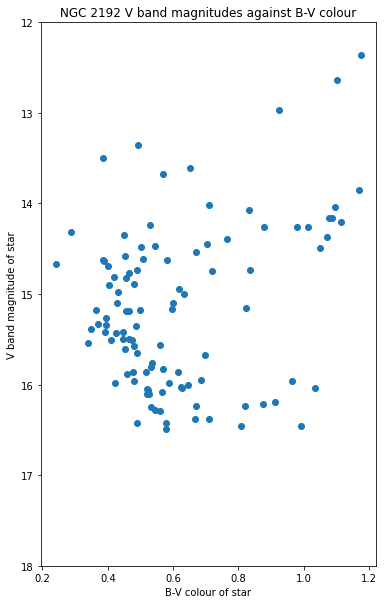

In [88]:
# get the relevant index
b_min_vs = [row[4] for row in float_lines]
vs = [row[3] for row in float_lines]


plt.scatter(b_min_vs, vs)
plt.ylim(18, 12)
plt.xlabel("B-V colour of star")
plt.ylabel("V band magnitude of star")
plt.title("NGC 2192 V band magnitudes against B-V colour")
plt.rcParams["figure.figsize"] = (6, 10)
plt.show()


<font color=blue> Figure 1: B-V colour of stars in NGC 2192 plotted against their V band magnitudes. Note that these axes correspond to/are a proxy for the same relatioship in the context of a H-R diagram.

# Q3b) Generate a Girardi isochrone using http://stev.oapd.inaf.it/cgi-bin/cmd for an age corresponding to the last digit of your student number multiplied by 100 Myr plus 100 Myr (i.e. last digit of 3 corrresponds to 400 Myr).

# Then use python and Jupyter to ingest this isochrone and then plot V -band absolute magnitude as a function of B − V colour. 

# Hint: see the lectures and supplementary files presented with lecture slides. Also check that your first set of UBVRI photometry agrees with the first line in the relevant text file using print.


# 12 marks

In [89]:
# My age is 300 Myr for a student number ending in 2.

with open("girardi_isochrone.dat", "r") as f:
    isochrone_lines = f.readlines()[12:]

split_lines_iso = map(lambda line: line.split(), isochrone_lines)
# note here the array slicing of elem 16 ensures that we don't try to convert the strings marking stages that appears in some of the lines into floats
float_lines_iso = list(map(lambda l: list(map(float, l[:16])), split_lines_iso))

print("Expected first line:", "8.48	0.15000001	0.1500	-2.4957	3.5240	5.1517	11.009	15.939	14.432	12.848	11.740	10.426	9.205	8.651	8.402	1.96093953")
print("Actual first line:", float_lines_iso[0])

Expected first line: 8.48	0.15000001	0.1500	-2.4957	3.5240	5.1517	11.009	15.939	14.432	12.848	11.740	10.426	9.205	8.651	8.402	1.96093953
Actual first line: [8.48, 0.15000001, 0.15, -2.4957, 3.524, 5.1517, 11.009, 15.939, 14.432, 12.848, 11.74, 10.426, 9.205, 8.651, 8.402, 1.96093953]


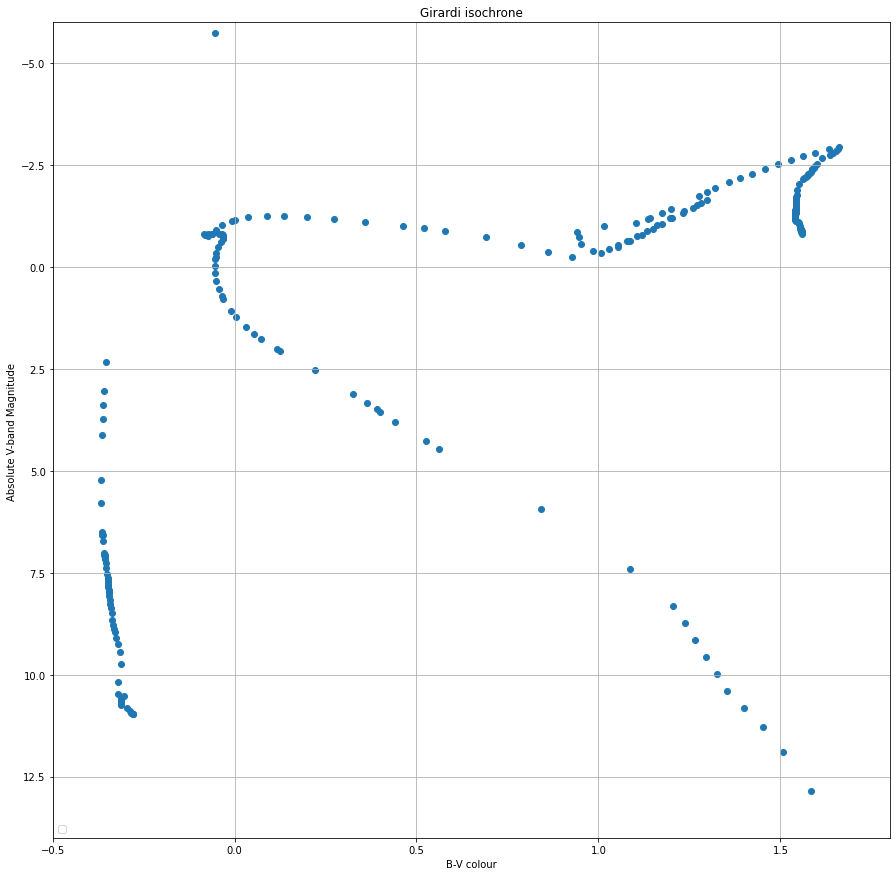

In [107]:
# some nice list comprehension and function mapping to produce our b-v array
iso_vs = [row[9] for row in float_lines_iso]
iso_bs = [row[8] for row in float_lines_iso]

import operator
iso_b_min_vs = list(map(operator.sub, iso_bs, iso_vs))

# print(iso_b_min_vs)
plt.axis([-0.5, 1.8, 14, -6.0]) 
plt.scatter(iso_b_min_vs, iso_vs)
plt.xlabel('B-V colour')          
plt.ylabel('Absolute V-band Magnitude ')
plt.title('Girardi isochrone')
plt.legend(loc='lower left')
plt.rcParams['figure.figsize'] = [15, 15]
plt.grid(True)
plt.show()


<font color=blue> Figure 2: Girardi Isochrone of 300 Myr. We start in the bottom right corner for low initial masses, then traverse up (brighter) and to the left (bluer) as we increase our initial mass. 

We can clearly see the effect that increasing initial mass has on the star's lifespan, as we begin to see stars that have already traversed onto the giant branches. The point at the tip of the asymptotic branch is from a star with initial mass M = 3.49848485 msol, and the very next data point is the traversal of the post-AGB stage all the way across to the single data point with magnitude of beyond -5, which resulted from a star with initial mass M = 3.49848580 msol. 

The sparsity of the data points in this post-AGB region indicates the extreme brevity of this stage of the star's life - even though the isochrone simulation is reducing the step size of M_init in this region substantially in an attempt to provide us with more data!

# Q3c) Offset the Giradi isochrone vertically (i.e. apply a distance modulus), so the Girardi isochrone matches the NGC 2192 main sequence. (For now just use a visual match, but more sophisticated methods of matching are possible.) Use the resulting offset to determine the distance modulus and distance to Coma star cluster. How does your distance compare with recent values from the literature?

# Hint - the top-left of the NGC 2192 sequence is easier to spot than the bottom right, where foreground/background stars complicate the picture.

# 11 marks

# Q3d) NGC 2192 has foreground dust extinction of E(B-V) = 0.20, so the B-V colours have been reddened by 0.20 magnitudes and the V-band apparent magnitudes are 0.62 fainter than they would be otherwise. Redo your distance estimate including this information.

# 6 marks

# Q3e) Generate Giradi isochrones for several specific ages, and use these to estimate the approximate age of NGC 2192 by overplotting the (offset) isochrones on the observed apparent V -band magnitude as a function of B − V colour. An age within a factor of two of the correct answer will suffice.

# 10 marks

# Q3f) Identify a star where the ID matches the last two digits of your student number. Print out the ID, B-V colour and V-band magnitude. 

# Given the star's location on the HR diagram, do you believe it is a main sequence star, giant star or a foreground/background star that is not in the cluster. Justify your answer.

# 7 marks